In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
## Step 1: Load and Preprocess Data
# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for pre-trained model input
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for pre-trained models
])

In [ ]:
!unzip -qq ./chip_data.zip -d data

In [ ]:
# Load dataset from a folder (structured as: dataset/class_name/images)
dataset_path = "./data/dataset/"
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

In [ ]:
# Display some input images
def show_sample_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(5, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # Convert tensor format (C, H, W) to (H, W, C)
        axes[i].imshow(image)
        axes[i].set_title(dataset.classes[label])
        axes[i].axis("off")
    plt.show()

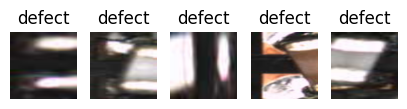

In [ ]:
# Show sample images from the training dataset
show_sample_images(train_dataset)

In [ ]:
# Get the total number of samples in the training dataset
print(f"Total number of training samples: {len(train_dataset)}")

# Get the shape of the first image in the dataset
first_image, label = train_dataset[0]
print(f"Shape of the first image: {first_image.shape}")

Total number of training samples: 172
Shape of the first image: torch.Size([3, 224, 224])


In [ ]:
# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
## Step 2: Load Pretrained Model and Modify for Transfer Learning
# Load a pre-trained VGG19 model
model = models.vgg19(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
from torchsummary import summary
# Print model summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# Modify the final fully connected layer to match the dataset classes
in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, 1)

In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# Freeze all layers except the final layer
for param in model.features.parameters():
    param.requires_grad = False  # Freeze feature extractor layers

In [ ]:
# Include the Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.classifier[-1].parameters(), lr=0.001)

In [ ]:
## Step 3: Train the Model
def train_model(model, train_loader,test_loader,num_epochs=10):
    train_losses = []
    val_losses = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1) # Move data to device and adjust shape
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Compute validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1) # Move data to device and adjust shape
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))
        model.train()

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    # Plot training and validation loss
    print("Name:Cynthia Mehul J")
    print("Register Number:212223240020")
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Epoch [1/10], Train Loss: 0.6064, Validation Loss: 0.4670
Epoch [2/10], Train Loss: 0.4688, Validation Loss: 0.3926
Epoch [3/10], Train Loss: 0.3880, Validation Loss: 0.3558
Epoch [4/10], Train Loss: 0.3378, Validation Loss: 0.3135
Epoch [5/10], Train Loss: 0.2886, Validation Loss: 0.2911
Epoch [6/10], Train Loss: 0.2622, Validation Loss: 0.2753
Epoch [7/10], Train Loss: 0.2376, Validation Loss: 0.2602
Epoch [8/10], Train Loss: 0.2437, Validation Loss: 0.2491
Epoch [9/10], Train Loss: 0.2380, Validation Loss: 0.2425
Epoch [10/10], Train Loss: 0.2312, Validation Loss: 0.2425
Name:Cynthia Mehul J
Register Number:212223240020


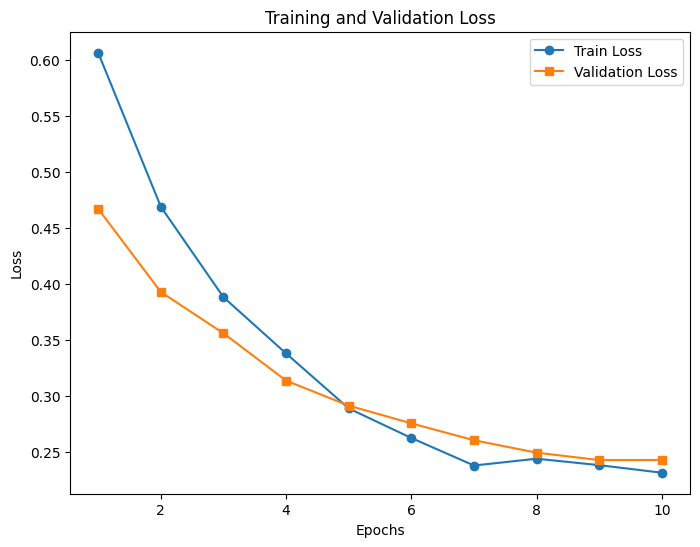

In [ ]:
# Train the model
train_model(model, train_loader,test_loader,num_epochs=10)

In [ ]:
## Step 4: Test the Model and Compute Confusion Matrix & Classification Report
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).int().squeeze(1) # Apply sigmoid and threshold for binary classification
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Name: Cynthia Mehul J")
    print("Register Number: 212223240020")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("Name: Cynthia Mehul J")
    print("Register Number: 212223240020")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

Test Accuracy: 0.9174
Name: Cynthia Mehul J
Register Number: 212223240020


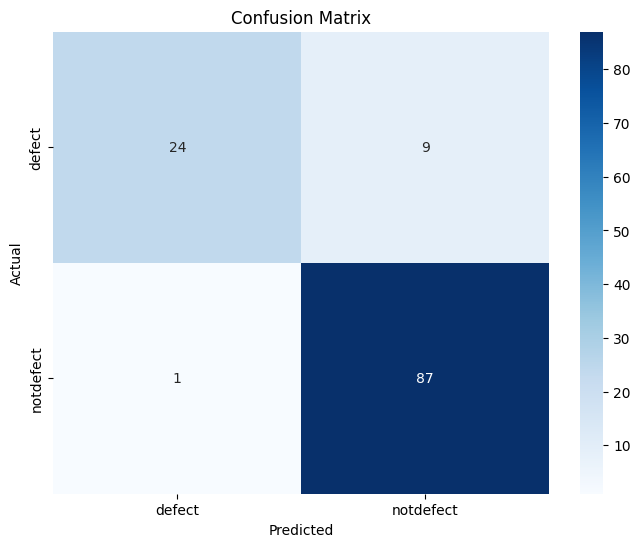

Name: Cynthia Mehul J
Register Number: 212223240020
Classification Report:
              precision    recall  f1-score   support

      defect       0.96      0.73      0.83        33
   notdefect       0.91      0.99      0.95        88

    accuracy                           0.92       121
   macro avg       0.93      0.86      0.89       121
weighted avg       0.92      0.92      0.91       121



In [ ]:
# Evaluate the model
test_model(model, test_loader)



In [ ]:
## Step 5: Predict on a Single Image and Display It
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]
    with torch.no_grad():
        image_tensor = image.unsqueeze(0).to(device)
        output = model(image_tensor)

        # Apply sigmoid to get probability, threshold at 0.5
        prob = torch.sigmoid(output)
        predicted = (prob > 0.5).int().item()


    class_names = class_names = dataset.classes
    # Display the image
    image_to_display = transforms.ToPILImage()(image.cpu()) # Move image to CPU for display
    plt.figure(figsize=(4, 4))
    plt.imshow(image_to_display)
    plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[predicted]}')
    plt.axis("off")
    plt.show()

    print(f'Actual: {class_names[label]}, Predicted: {class_names[predicted]}')

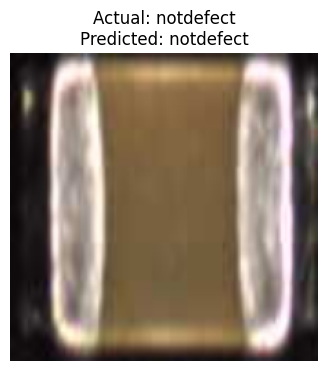

Actual: notdefect, Predicted: notdefect


In [ ]:
# Example Prediction
predict_image(model, image_index=120, dataset=test_dataset)


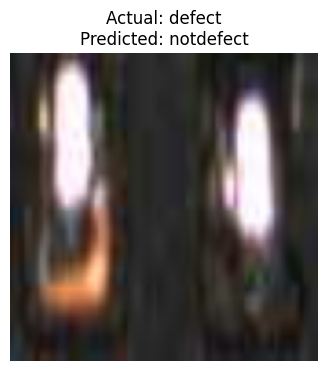

Actual: defect, Predicted: notdefect


In [ ]:
#Example Prediction
predict_image(model, image_index=25, dataset=test_dataset)

Epoch [1/10], Train Loss: 0.4660, Validation Loss: 0.3835
Epoch [2/10], Train Loss: 0.3841, Validation Loss: 0.3357
Epoch [3/10], Train Loss: 0.3410, Validation Loss: 0.3020
Epoch [4/10], Train Loss: 0.3094, Validation Loss: 0.2815
Epoch [5/10], Train Loss: 0.2852, Validation Loss: 0.2605
Epoch [6/10], Train Loss: 0.2343, Validation Loss: 0.2471
Epoch [7/10], Train Loss: 0.2193, Validation Loss: 0.2383
Epoch [8/10], Train Loss: 0.2093, Validation Loss: 0.2324
Epoch [9/10], Train Loss: 0.2011, Validation Loss: 0.2294
Epoch [10/10], Train Loss: 0.1780, Validation Loss: 0.2184
Name:Cynthia Mehul J
Register Number:212223240020


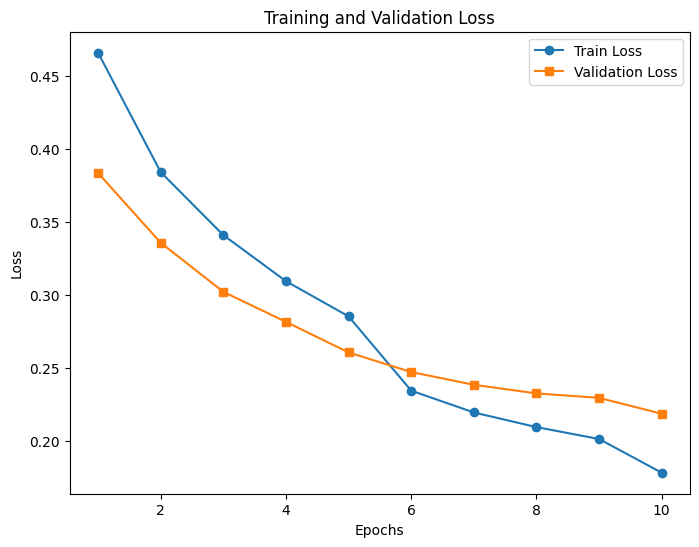

In [ ]:
# Train the model
train_model(model, train_loader, test_loader, num_epochs=20)

Test Accuracy: 0.9339
Name: Cynthia Mehul J
Register Number: 212223240020


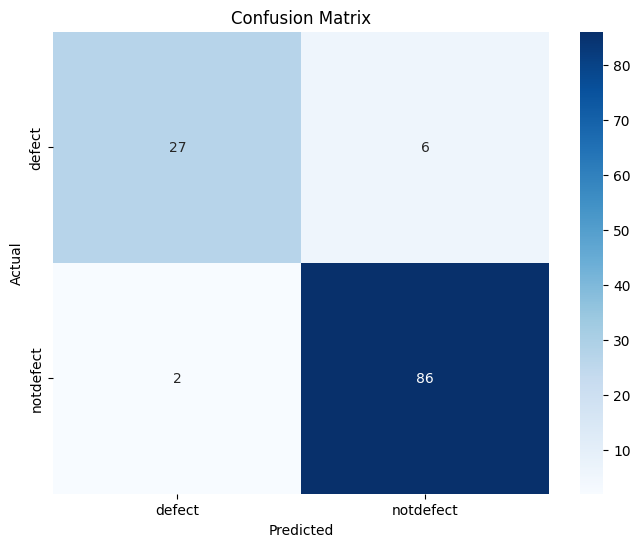

Name: Cynthia Mehul J
Register Number: 212223240020
Classification Report:
              precision    recall  f1-score   support

      defect       0.93      0.82      0.87        33
   notdefect       0.93      0.98      0.96        88

    accuracy                           0.93       121
   macro avg       0.93      0.90      0.91       121
weighted avg       0.93      0.93      0.93       121



In [ ]:
# Evaluate the model
test_model(model, test_loader)

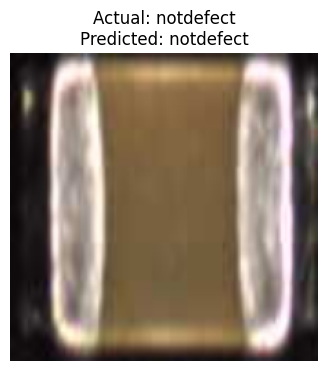

Actual: notdefect, Predicted: notdefect


In [ ]:
# Example Prediction
predict_image(model, image_index=55, dataset=test_dataset)

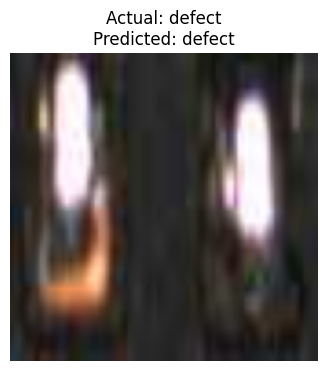

Actual: defect, Predicted: defect


In [ ]:
#Example Prediction
predict_image(model, image_index=25, dataset=test_dataset)